# Assignment 3

### First import all the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Select Columns and fit/predict method

In [2]:
fit_cols_num = ["OverallQual","OverallCond","MSSubClass","LotFrontage"]
# 0, 1 or 2 (3 for all)
LinReg_Lasso_Ridge = 2

Now I need to figure out what to focus on, I might want the fields:
    - (YearRemodAdd - YrSold)*-1 = delta_years_mod_and_sold NO
    - LotArea NO
    - LotFrontage NO
    - OverallCond OK
    - OverallQual OK
    - MSZoning OK
    - MasVnrArea NO
    - GarageArea NO

# Load datasets

### Load Test Data

In [3]:
df_houseprices_testdata = pd.read_csv('test.csv', sep=',')
df_houseprices_testdata.set_index(["Id"]).head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Load Train Data

In [4]:
df_houseprices_traindata = pd.read_csv('train.csv', sep=',')
df_houseprices_traindata = df_houseprices_traindata.set_index(["Id"])
df_houseprices_traindata.columns[df_houseprices_traindata.dtypes != object]


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

## filter overallcond less than 3
If we can categorize overallcondition on both the test and training sets, we might get a more precise estimation

In [5]:
filter_test_under_three = df_houseprices_testdata["OverallCond"]<3
filter_train_under_three = df_houseprices_traindata["OverallCond"]<3
df_houseprices_traindata.loc[:,("OverallCond")][filter_train_under_three] = 3
df_houseprices_testdata.loc[:,("OverallCond")][filter_test_under_three] = 3

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# Analyze selected columns

In [6]:
df_houseprices_traindata[fit_cols_num].describe()

,OverallQual,OverallCond,MSSubClass,LotFrontage,GarageArea
count,1460.000000,1460.000000,1460.000000,1201.000000,1460.000000
mean,6.099315,5.580137,56.897260,70.049958,472.980137
std,1.382997,1.098826,42.300571,24.284752,213.804841
min,1.000000,3.000000,20.000000,21.000000,0.000000
25%,5.000000,5.000000,20.000000,59.000000,334.500000
50%,6.000000,5.000000,50.000000,69.000000,480.000000
75%,7.000000,6.000000,70.000000,80.000000,576.000000
max,10.000000,9.000000,190.000000,313.000000,1418.000000


## Analyze specific feature with a graph

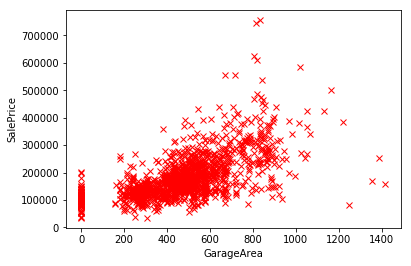

In [7]:
xcoloumnname= "GarageArea"
ycoloumnname= "SalePrice"
plt.plot(df_houseprices_traindata[xcoloumnname], df_houseprices_traindata[ycoloumnname], 'rx')
plt.ylabel(ycoloumnname)
plt.xlabel(xcoloumnname)
plt.show()

## Numeric Columns Select

Now that we have separated them into coloumns, we can select the other Quality, condition and LotArea coloumns. 
Then we join them together, we now just need the last coloumn; "delta_years_mod_and_sold"

In [8]:
# train data
df_train_numeric_cols = pd.DataFrame(df_houseprices_traindata[fit_cols_num])
# remove null in LotFrontage
df_train_numeric_cols["LotFrontage"] = df_train_numeric_cols["LotFrontage"].fillna(df_train_numeric_cols["LotFrontage"].mean())
# GarageArea
# df_train_numeric_cols["GarageArea"] = df_train_numeric_cols["GarageArea"].fillna(0)

In [9]:
# test data
df_test_numeric_cols = pd.DataFrame(df_houseprices_testdata[fit_cols_num])
# remove null in LotFrontage
df_test_numeric_cols["LotFrontage"] = df_test_numeric_cols["LotFrontage"].fillna(df_test_numeric_cols["LotFrontage"].mean())
# GarageArea
# df_test_numeric_cols["GarageArea"] = df_test_numeric_cols["GarageArea"].fillna(0)

## MSZoning analysis

In [10]:
df_houseprices_traindata["MSZoning"].describe()

count     1460
unique       5
top         RL
freq      1151
Name: MSZoning, dtype: object

It is obvious that there is many low density residential zoned houses, I'll now separate the different MSZones to their own coloumn

In [11]:
MSZones_train_seperated = pd.get_dummies(df_houseprices_traindata["MSZoning"], prefix="MSZone", drop_first=True, dtype=int)
MSZones_test_seperated = pd.get_dummies(df_houseprices_testdata["MSZoning"], prefix="MSZone", drop_first=True, dtype=int)

## Join num_cols with MSZones_seperated

In [12]:
df_train_numeric_cols = df_train_numeric_cols.join(MSZones_train_seperated)
df_test_numeric_cols = df_test_numeric_cols.join(MSZones_test_seperated)


## Calculate delta years = yr_sold to yr_mod

We calculate the delta_years_mod_and_sold like so: (YearRemodAdd - YrSold)*-1

In [13]:
#calculate for train data
yearRemodAdd = df_houseprices_traindata["YearRemodAdd"]
yearsold = df_houseprices_traindata["YrSold"]
calculatedCols = (yearRemodAdd-yearsold) * -1
df_train_delta_years_mod_and_sold = pd.DataFrame(calculatedCols,columns=["delta_years_mod_and_sold"])

#calculate for test data
yearRemodAdd = df_houseprices_testdata["YearRemodAdd"]
yearsold = df_houseprices_testdata["YrSold"]
calculatedCols = (yearRemodAdd-yearsold) * -1
df_test_delta_years_mod_and_sold = pd.DataFrame(calculatedCols,columns=["delta_years_mod_and_sold"])

## Join num_cols with Delta years

In [14]:
#df_train_numeric_cols = df_train_numeric_cols.join(df_train_delta_years_mod_and_sold)
#df_test_numeric_cols = df_test_numeric_cols.join(df_test_delta_years_mod_and_sold)

# LinearRegression

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

a = 40

#instanciate
linReg = LinearRegression()
lasso = Lasso(alpha = a)
ridge = Ridge(alpha = a)


#define X and y
X_fit_train = df_train_numeric_cols
X_test = df_test_numeric_cols
y_fit_train = df_houseprices_traindata.SalePrice

#fit
linReg.fit(X_fit_train,y_fit_train)
lasso.fit(X_fit_train, y_fit_train)
ridge.fit(X_fit_train, y_fit_train)

print("Model fitted, with train data")

Model fitted, with train data


In [16]:
#Predict train data for control
if LinReg_Lasso_Ridge == 0:
    y_train_predict = linReg.predict(X_fit_train)
    
elif LinReg_Lasso_Ridge == 1:
    y_train_predict = lasso.predict(X_fit_train)
    
elif LinReg_Lasso_Ridge == 2:
    y_train_predict = ridge.predict(X_fit_train)
    
elif LinReg_Lasso_Ridge == 3:
    linreg_pred = linReg.predict(X_fit_train)
    lasso_pred = lasso.predict(X_fit_train)
    ridge_pred = ridge.predict(X_fit_train)
    y_train_predict = np.mean([linreg_pred, lasso_pred, ridge_pred], axis=0)

# to dataframe
df_y_train_predict = pd.DataFrame(y_train_predict, columns=["SalePrice"])

print("Using:")
#Predict test data for submission
if LinReg_Lasso_Ridge == 0:
    y_test_predict = linReg.predict(X_test)
    print(" LinReg")
elif LinReg_Lasso_Ridge == 1:
    y_test_predict = lasso.predict(X_test)
    print(" Lasso")
elif LinReg_Lasso_Ridge == 2:
    y_test_predict = ridge.predict(X_test)
    print(" Ridge")
elif LinReg_Lasso_Ridge == 3:
    linreg_pred = linReg.predict(X_test)
    print(linreg_pred)
    lasso_pred = lasso.predict(X_test)
    print(lasso_pred)
    ridge_pred = ridge.predict(X_test)
    print(ridge_pred)
    y_test_predict = np.mean([linreg_pred, lasso_pred, ridge_pred], axis=0)
    print(y_test_predict)
# to dataframe
df_y_test_predict = pd.DataFrame(y_test_predict, columns=["SalePrice"])
print(df_y_test_predict.head())

# test for negative values
if(np.any(df_y_test_predict[df_y_test_predict.SalePrice < 0])):
    df_y_test_predict = np.abs(df_y_test_predict["SalePrice"])
    print("Corrected negative values in test prediction")
else:
    print("No negative values in test prediction")
    
    
if(np.any(df_y_train_predict[df_y_train_predict.SalePrice < 0])):
    df_y_train_predict = np.abs(df_y_train_predict["SalePrice"])
    print("Corrected negative values in training prediction")
else:
    print("No negative values in training prediction")

Using:
[159825.00504395 163874.84322713 152126.65317481 ... 189257.43169171
 108068.08636483 233771.73002738]
[156183.92530486 163867.32440217 152107.15619367 ... 189331.69300701
 108075.68653536 233687.41131154]
[155644.82910253 162793.63274402 152936.11860992 ... 191418.40567272
 107753.90062452 233239.18550387]
[157217.91981711 163511.93345777 152389.9759928  ... 190002.51012382
 107965.8911749  233566.1089476 ]
       SalePrice
0  157217.919817
1  163511.933458
2  152389.975993
3  187434.996465
4  241678.573178
Corrected negative values in test prediction
Corrected negative values in training prediction


#### For analyzing if values are negative

In [17]:
#df_houseprices_traindata[fit_cols_num].iloc[[88,375,533,636,916,1100]]

In [18]:
#df_houseprices_traindata[fit_cols_num].describe().T

## Mean Sq Error

In [19]:
from sklearn import metrics
price_log_real = np.log(df_houseprices_traindata.SalePrice)
price_log_predict = np.log(df_y_train_predict)


metrics.mean_squared_error(price_log_real, price_log_predict)


0.061947596382706804

# to CSV

In [20]:
df_y_test_predict.head()

0    157217.919817
1    163511.933458
2    152389.975993
3    187434.996465
4    241678.573178
Name: SalePrice, dtype: float64

In [21]:
sub = pd.read_csv('sample_submission.csv')
sub.SalePrice = df_y_test_predict
sub.to_csv('submission.csv', index=False)

### Notes:

That was.. Bad ... we think?
Let's try remove some columns and see what that does to our prediction quality
- Remove delta year: got worse!
- Remove delta year and MSZones: Worse!
- Add Salecondition: Slightly better!
- Add Neighboorhood: A lot better!